# Clasificación de emociones en EmoEvent (ES)
**Estudio exploratorio de tres modelos (baseline clásico, fine-tuning y zero-shot)**

**Dataset:** [EmoEvent](https://github.com/fmplaza/EmoEvent) — 8 clases: `anger, sadness, joy, disgust, fear, surprise, offensive, other`  
> En los *splits en español (es)* no suele aparecer `other`. Reportaremos **las etiquetas realmente presentes** en cada split.

**Requerimientos del trabajo:**
- Explorar **3 modelos** (entrenados, fine-tuning o listos).  
- Reportar resultados **por emoción** y **por evento**, incluir **matriz de confusión** y otros análisis pertinentes.  
- Entregar **notebook en GitHub** (link al repo).  
- Notebook **detallado paso a paso**.


# Parte 1 — Instalación y Setup

**Objetivo:** Dejar el entorno listo para reproducibilidad, descargar el dataset y fijar estructura de carpetas.

**En esta sección haremos:**
1) Verificar GPU/versión de Python.  
2) Instalar dependencias (`transformers`, `datasets`, `sklearn`, utilidades de limpieza).  
3) Clonar **EmoEvent** y cargar los *splits* en español (`train/dev/test`).  
4) Crear carpetas de salida y fijar semillas para reproducibilidad.

>  Si actualizas paquetes con la sesión ya abierta, puede ser necesario


In [12]:
!nvidia-smi -L || echo "Sin GPU visible"
!python --version
!pip -q install pandas numpy scikit-learn matplotlib seaborn emoji clean-text[gpl] unidecode datasets evaluate accelerate "transformers==4.55.4"

from pathlib import Path
import random, numpy as np
import pandas as pd
from IPython.display import display

!rm -rf /content/EmoEvent
!git clone --depth 1 https://github.com/fmplaza/EmoEvent.git /content/EmoEvent

ES_DIR = Path("/content/EmoEvent/splits/es")
assert (ES_DIR/"train.tsv").exists() and (ES_DIR/"dev.tsv").exists() and (ES_DIR/"test.tsv").exists()
read_tsv = lambda p: pd.read_csv(p, sep="\t", dtype=str).fillna("")
df_train = read_tsv(ES_DIR/"train.tsv")
df_dev   = read_tsv(ES_DIR/"dev.tsv")
df_test  = read_tsv(ES_DIR/"test.tsv")

BASE_DIR = Path("/content")
DATA_DIR = ES_DIR
OUT_DIR  = BASE_DIR / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)
SEED = 42
random.seed(SEED); np.random.seed(SEED)
try:
    import torch
    torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
except Exception as e:
    print(e)

print("DATA_DIR:", DATA_DIR)
print("OUT_DIR:", OUT_DIR)
print("SEED:", SEED)
print("Shapes (train, dev, test):", df_train.shape, df_dev.shape, df_test.shape)
print("Columnas:", list(df_train.columns))
display(df_train.head(3))


GPU 0: Tesla T4 (UUID: GPU-89d77bba-0d2c-cc6c-1a47-c882eed9f9bf)
Python 3.12.11
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 73.9 MB/s eta 0:00:00
Cloning into '/content/EmoEvent'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 15 (delta 0), reused 7 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 2.26 MiB | 9.78 MiB/s, done.
DATA_DIR: /content/EmoEvent/splits/es
OUT_DIR: /content/outputs
SEED: 42
Shapes (train, dev, test): (5723, 5) (844, 5) (1656, 5)
Columnas: ['id', 'event', 'tweet', 'offensive', 'emotion']


,id,event,tweet,offensive,emotion
0,a0c1a858-a9b8-4cb1-8a81-1602736ff5b8,GameOfThrones,La Gran Guerra de #JuegoDeTronos nos ha dejado...,NO,others
1,9b272817-a231-4f68-bdf4-3350d4919330,Venezuela,El golpe de Estado en #Venezuela está más lejo...,NO,others
2,4bd5b1e5-4b74-440a-82f4-c2567a241011,NotreDame,No tengo una foto en la catedral de #NotreDame...,NO,sadness


# Parte 2 — EDA (Análisis Exploratorio)


Etiquetas: ['anger', 'disgust', 'fear', 'joy', 'offensive', 'other', 'sadness', 'surprise']
Distribución por clase (train)


,count,pct
label8,,
other,2725,0.476149
joy,1180,0.206186
sadness,685,0.119692
offensive,470,0.082125
anger,339,0.059235
surprise,215,0.037568
fear,63,0.011008
disgust,46,0.008038


Distribución por clase (dev)


,count,pct
label8,,
other,404,0.478673
joy,174,0.206161
sadness,104,0.123223
offensive,76,0.090047
anger,44,0.052133
surprise,30,0.035545
fear,7,0.008294
disgust,5,0.005924


Distribución por clase (test)


,count,pct
label8,,
other,753,0.454710
joy,327,0.197464
sadness,183,0.110507
anger,142,0.085749
offensive,140,0.084541
surprise,61,0.036836
disgust,31,0.018720
fear,19,0.011473


TRAIN nulls


,nulls
id,0
event,0
tweet,0
offensive,0
emotion,0
label8,0


TRAIN duplicados por id: 0 por tweet: 2


,count,mean,std,min,25%,50%,75%,max
_len_char,5723.0,150.889394,67.529880,32.0,97.5,137.0,197.0,304.0
_len_tok,5723.0,22.300891,11.129704,4.0,13.0,20.0,29.0,59.0


DEV nulls


,nulls
id,0
event,0
tweet,0
offensive,0
emotion,0
label8,0


DEV duplicados por id: 0 por tweet: 0


,count,mean,std,min,25%,50%,75%,max
_len_char,844.0,151.734597,67.484514,34.0,97.0,137.5,199.25,304.0
_len_tok,844.0,22.488152,11.349034,4.0,13.0,19.5,30.00,56.0


TEST nulls


,nulls
id,0
event,0
tweet,0
offensive,0
emotion,0
label8,0


TEST duplicados por id: 29 por tweet: 29


,count,mean,std,min,25%,50%,75%,max
_len_char,1656.0,153.099034,159.107165,0.0,98.0,138.0,196.25,5978.0
_len_tok,1656.0,22.310386,20.594817,0.0,13.0,20.0,29.00,723.0


Fugas entre splits (tweets): train-dev: 0 train-test: 0 dev-test: 0
Señales en TRAIN


,ratio
has_url,0.474227
has_@,0.000000
has_#,1.000000
has_emoji,0.197798


Señales por clase (TRAIN)


,signal,ratio,label
0,has_url,0.271386,anger
1,has_@,0.000000,anger
2,has_#,1.000000,anger
3,has_emoji,0.097345,anger
4,has_url,0.304348,disgust
5,has_@,0.000000,disgust
6,has_#,1.000000,disgust
7,has_emoji,0.108696,disgust
8,has_url,0.285714,fear
9,has_@,0.000000,fear


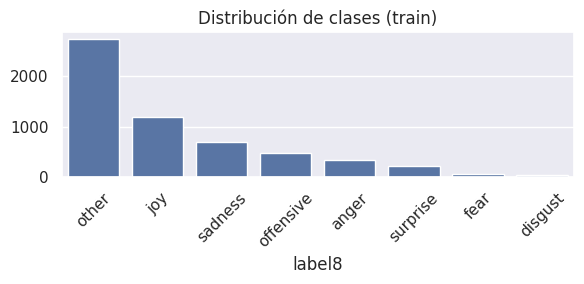

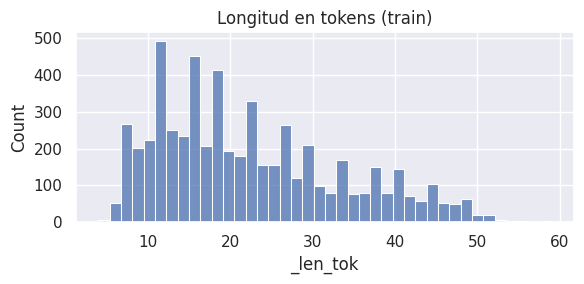

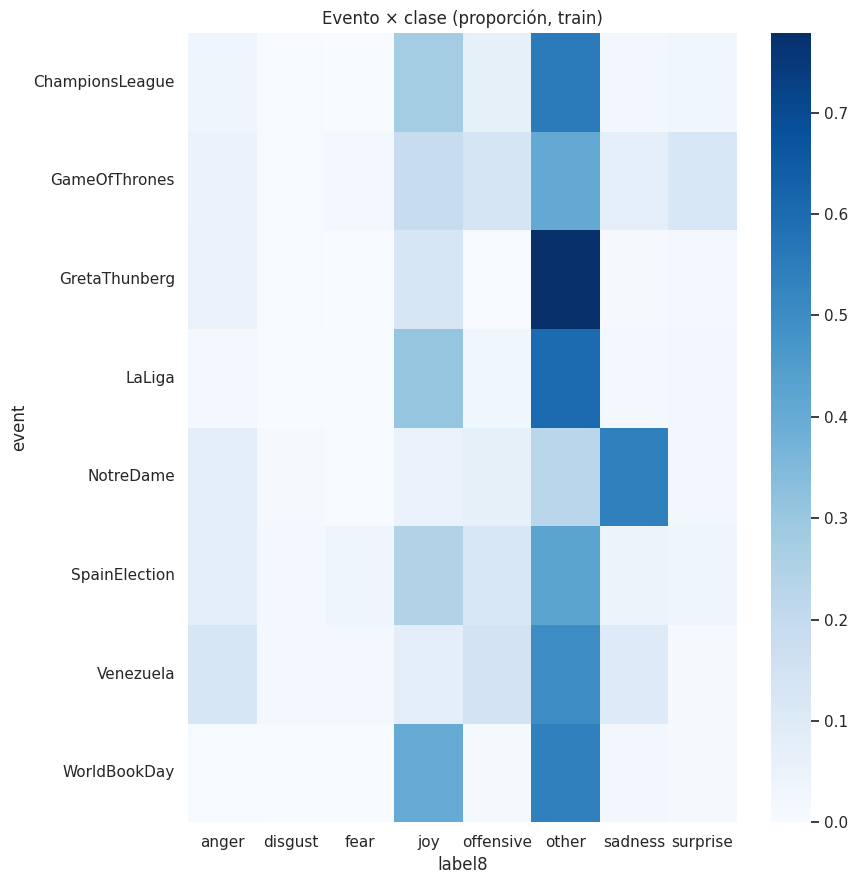

Muestrario por clase (train)


,event,label8,tweet
0,SpainElection,anger,"Independientemente de quién gane, que 200.000 ..."
1,Venezuela,anger,USER USER No a la toma violenta de #Venezuela...
2,NotreDame,anger,En un momento trágico como el que vive la #Not...
3,GameOfThrones,disgust,Llevo 5 minutos viendo el tercer episodio de l...
4,Venezuela,disgust,USER USER Madre mía que horror!! Y en USER le...
5,SpainElection,disgust,"Pues a la vista de los resultados, USER y USER..."
6,GameOfThrones,fear,Esto se va a poner feo pero muy feo #GameOfTho...
7,SpainElection,fear,A mí me da: miedo #ElecccionesGenerales28A htt...
8,GameOfThrones,fear,Viendo el capitulo 3 de #JuegoDeTronos y solo ...
9,LaLiga,joy,USER Solo basto la entrada de Messi para que ...


In [13]:
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from IPython.display import display

ALL_LABELS_8 = ['anger','sadness','joy','disgust','fear','surprise','offensive','other']

def add_label8(df):
    d = df.copy()
    off = d["offensive"].str.upper().str.strip()
    emo = d["emotion"].str.lower().str.strip().replace({"others":"other"})
    d["label8"] = np.where(off=="OFF","offensive",emo)
    d = d[d["label8"].isin(ALL_LABELS_8)].reset_index(drop=True)
    return d

df_train = add_label8(df_train)
df_dev   = add_label8(df_dev)
df_test  = add_label8(df_test)

LABELS = sorted(pd.concat([df_train["label8"], df_dev["label8"], df_test["label8"]]).unique())
print("Etiquetas:", LABELS)

def dist_tbl(df, col):
    vc = df[col].value_counts()
    return pd.DataFrame({"count":vc, "pct":vc/vc.sum()})

print("Distribución por clase (train)"); display(dist_tbl(df_train,"label8"))
print("Distribución por clase (dev)");   display(dist_tbl(df_dev,"label8"))
print("Distribución por clase (test)");  display(dist_tbl(df_test,"label8"))

for name, d in [("TRAIN",df_train),("DEV",df_dev),("TEST",df_test)]:
    print(name,"nulls"); display(d[["id","event","tweet","offensive","emotion","label8"]].isna().sum().to_frame("nulls"))
    d["_len_char"] = d["tweet"].str.len()
    d["_len_tok"]  = d["tweet"].str.split().apply(len)
    print(name,"duplicados por id:", d["id"].duplicated().sum(), "por tweet:", d["tweet"].duplicated().sum())
    display(d[["_len_char","_len_tok"]].describe().T)

leak_td = set(df_train["tweet"]).intersection(set(df_dev["tweet"]))
leak_tt = set(df_train["tweet"]).intersection(set(df_test["tweet"]))
leak_dt = set(df_dev["tweet"]).intersection(set(df_test["tweet"]))
print("Fugas entre splits (tweets): train-dev:",len(leak_td),"train-test:",len(leak_tt),"dev-test:",len(leak_dt))

url_re  = re.compile(r'http\S+|www\.\S+')
at_re   = re.compile(r'@\w+')
hash_re = re.compile(r'#\w+')
emoji_re = re.compile(r'[\U0001F300-\U0001FAFF]')

def tweet_signals(df):
    s = df["tweet"]
    return pd.DataFrame({
        "has_url":[s.str.contains(url_re).mean()],
        "has_@":[s.str.contains(at_re).mean()],
        "has_#":[s.str.contains(hash_re).mean()],
        "has_emoji":[s.str.contains(emoji_re).mean()],
    }).T.rename(columns={0:"ratio"})

print("Señales en TRAIN"); display(tweet_signals(df_train))

rows=[]
for lab, g in df_train.groupby("label8"):
    sig = tweet_signals(g).assign(label=lab).reset_index().rename(columns={"index":"signal"})
    rows.append(sig)
sig_by_label = pd.concat(rows, ignore_index=True)
print("Señales por clase (TRAIN)"); display(sig_by_label)

sns.set_theme()
vc = df_train["label8"].value_counts()
plt.figure(figsize=(6,3)); sns.barplot(x=vc.index, y=vc.values); plt.title("Distribución de clases (train)"); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3)); sns.histplot(df_train["_len_tok"], bins=40); plt.title("Longitud en tokens (train)"); plt.tight_layout(); plt.show()

ct = pd.crosstab(df_train["event"], df_train["label8"], normalize="index")
plt.figure(figsize=(9,9)); sns.heatmap(ct, cmap="Blues"); plt.title("Evento × clase (proporción, train)"); plt.tight_layout(); plt.show()

def sample_by_label(df, n=3, seed=42):
    out=[]
    for lab, g in df.groupby("label8", sort=True):
        k = min(n,len(g))
        if k>0:
            out.append(g.sample(n=k, random_state=seed)[["event","label8","tweet"]])
    return pd.concat(out).reset_index(drop=True)

print("Muestrario por clase (train)"); display(sample_by_label(df_train, n=3))


# Parte 2 — Limpieza de texto


In [14]:
import re, unicodedata, pandas as pd, numpy as np

URL_RE   = re.compile(r'http\S+|www\.\S+')
AT_RE    = re.compile(r'@\w+')
HASH_RE  = re.compile(r'#')
RT_RE    = re.compile(r'\bRT\b:?')
USER_RE  = re.compile(r'\bUSER\b', flags=re.IGNORECASE)
WS_RE    = re.compile(r'\s+')
PUNKS_RE = re.compile(r'([!?¡¿.,;:])\1{2,}')
LAUGH_RE = re.compile(r'\b(ja|je|ji|jo|ju){2,}\b|jaja+|jeje+|jiji+|jojo+|juju+|x+d+', re.IGNORECASE)
LETTER_ELONG_RE = re.compile(r'([A-Za-zÁÉÍÓÚÜÑáéíóúüñ])\1{2,}')
EMOJI_RE = re.compile(r'[\U00002600-\U000026FF\U00002700-\U000027BF\U0001F1E0-\U0001F1FF\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FAFF]', flags=re.UNICODE)
EMOTICON_RE = re.compile(r'(:-?\)|:-?\(|;-?\)|:-?D|xD|XD|:-?P|<3|:\')', re.IGNORECASE)

ES_STOPWORDS = {
    'a','acá','ahí','al','algo','alguna','algunas','alguno','algunos','allá','alli','allí','ante','antes','aquel','aquella','aquellas','aquello','aquellos','aquí','así','aun','aún','aunque','bajo','bien','cada','casi','como','con','contra','cual','cuales','cualquier','cualquiera','cualquieras','cuan','cuándo','cuanto','cuantos','de','del','desde','donde','dos','el','él','ella','ellas','ello','ellos','en','entre','era','erais','eran','eras','eres','es','esa','esas','ese','eso','esos','esta','estaba','estabais','estaban','estabas','estad','estada','estadas','estado','estados','estamos','estando','estar','estaremos','estará','estarán','estarás','estaré','estaréis','estaría','estaríais','estaríamos','estarían','estarías','estas','este','estemos','esto','estos','estoy','estuve','estuviera','estuvierais','estuvieran','estuvieras','estuvieron','estuviese','estuvieseis','estuviesen','estuvieses','estuvimos','estuviste','estuvisteis','estuvo','fin','fue','fuera','fuerais','fueran','fueras','fueron','fuese','fueseis','fuesen','fueses','fui','fuimos','ha','habida','habidas','habido','habidos','habiendo','habremos','habrá','habrán','habrás','habré','habréis','habría','habríais','habríamos','habrían','habrías','han','has','hasta','hay','haya','hayamos','hayan','hayas','he','hemos','hube','hubiera','hubierais','hubieran','hubieras','hubieron','hubiese','hubieseis','hubiesen','hubieses','hubimos','hubiste','hubisteis','hubo','la','las','le','les','lo','los','mas','más','me','mi','mis','mismo','mucha','muchas','mucho','muchos','muy','nada','nos','nosotras','nosotros','otra','otras','otro','otros','para','pero','poco','por','porque','que','qué','quien','quién','quienes','quienesquiera','quienquiera','se','sea','seamos','sean','seas','seremos','será','serán','serás','seré','seréis','sería','seríais','seríamos','serían','serías','si','sí','sido','siempre','so','sobre','sois','solamente','solo','somos','son','su','sus','suya','suyas','suyo','suyos','tanto','te','teneis','tenéis','tenemos','tengo','tener','tendrá','tendrán','tendrás','tendré','tendréis','tendría','tendríais','tendríamos','tendrían','tendrías','ti','tiene','tienen','tienes','todo','todos','tu','tus','tuya','tuyas','tuyo','tuyos','un','una','uno','unos','vosotras','vosotros','vuestra','vuestras','vuestro','vuestros','ya','y'
}
CRUCIALES = {'no','nunca','jamás','sin','ni','tampoco','nadie','ninguno','ninguna','ningún','nada'}
STOPWORDS = ES_STOPWORDS - CRUCIALES

def _norm(s):
    return unicodedata.normalize('NFC', str(s))

def _tok_filter(tokens):
    out=[]
    for t in tokens:
        if not t:
            continue
        if t in STOPWORDS:
            continue
        if len(t)==1 and t not in {'no','y','o'}:
            continue
        out.append(t)
    return out

def clean_remove_emoji_stopwords(text):
    s = _norm(text)
    s = URL_RE.sub(' ', s)
    s = AT_RE.sub(' ', s)
    s = HASH_RE.sub('', s)
    s = RT_RE.sub(' ', s)
    s = USER_RE.sub(' ', s)
    s = EMOJI_RE.sub(' ', s)
    s = EMOTICON_RE.sub(' ', s)
    s = PUNKS_RE.sub(r'\1\1', s)
    s = LAUGH_RE.sub(' ', s)
    s = LETTER_ELONG_RE.sub(r'\1\1', s)
    s = s.lower()
    s = WS_RE.sub(' ', s).strip()
    toks = s.split()
    toks = _tok_filter(toks)
    s = ' '.join(toks).strip()
    return s if s else "<empty>"

for d in (df_train, df_dev, df_test):
    d["text_clean"] = d["tweet"].apply(clean_remove_emoji_stopwords)

print("vacíos:", (df_train.text_clean=="<empty>").sum(), (df_dev.text_clean=="<empty>").sum(), (df_test.text_clean=="<empty>").sum())
display(df_train[["tweet","text_clean"]].head(10))


vacíos: 0 0 30


,tweet,text_clean
0,La Gran Guerra de #JuegoDeTronos nos ha dejado...,gran guerra juegodetronos dejado momentos recu...
1,El golpe de Estado en #Venezuela está más lejo...,golpe venezuela está lejos final elif. venezue...
2,No tengo una foto en la catedral de #NotreDame...,no foto catedral notredame secuencia hermosa..
3,#NotreDame nunca llegue a visitar tan grandios...,notredame nunca llegue visitar tan grandiosa c...
4,A tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos,tomar culo crush juegodetronos
5,Bueno declaro Moscú la nueva y renovada Messig...,bueno declaro moscú nueva renovada messigrado....
6,Huelga Internacional Contra el Cambio Climátic...,huelga internacional cambio climático 15 marzo...
7,"""Sofia es mujer para un rico y yo soy pobre y ...","""sofia mujer rico yo soy pobre humilde"" 28a el..."
8,"Ya se fue, lo hubiese hecho hace años y evitab...","fue, hecho hace años evitaba matar tanta gente..."
9,➡️AVANCE INFORMATIVO ▪️Valoraciones de los res...,️avance informativo ▪️valoraciones resultados ...


# Parte 3 — Modelo 1: TF-IDF + LinearSVC


Mejor C (dev): 0.5 | F1-macro(dev): 0.4687
              precision    recall  f1-score   support

       anger      0.100     0.049     0.066       142
     disgust      0.000     0.000     0.000        31
        fear      0.000     0.000     0.000        19
         joy      0.241     0.239     0.240       327
   offensive      0.598     0.521     0.557       140
       other      0.494     0.559     0.525       753
     sadness      0.131     0.153     0.141       183
    surprise      0.019     0.016     0.018        61

    accuracy                          0.367      1656
   macro avg      0.198     0.192     0.193      1656
weighted avg      0.347     0.367     0.355      1656



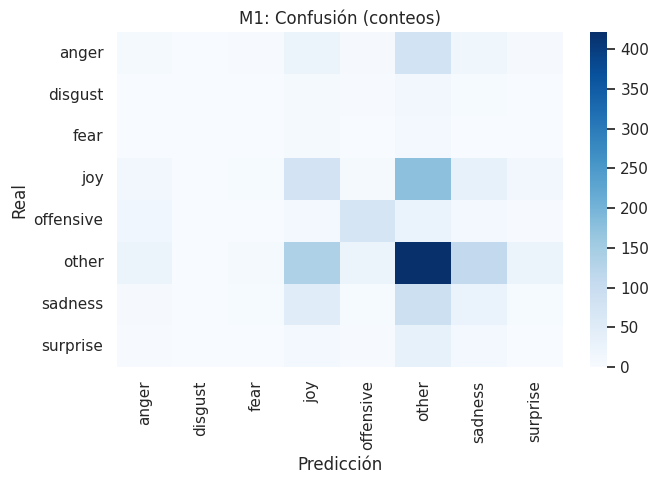

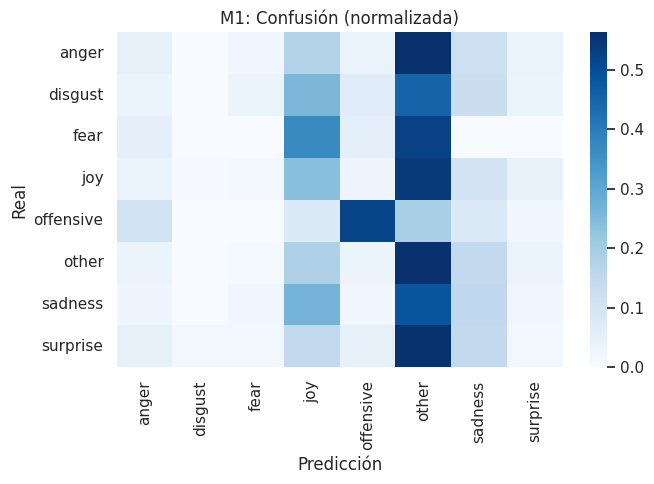

,label,precision,recall,f1,support
0,other,0.494131,0.559097,0.524611,753
1,joy,0.240741,0.238532,0.239631,327
2,sadness,0.130841,0.153005,0.141058,183
3,anger,0.100000,0.049296,0.066038,142
4,offensive,0.598361,0.521429,0.557252,140
5,surprise,0.019231,0.016393,0.017699,61
6,disgust,0.000000,0.000000,0.000000,31
7,fear,0.000000,0.000000,0.000000,19


,event,macro_f1,n
8,WorldBookDay,0.210682,240
7,Venezuela,0.196266,234
1,ChampionsLeague,0.185262,232
4,LaLiga,0.176491,119
6,SpainElection,0.173535,218
2,GameOfThrones,0.161729,219
5,NotreDame,0.134683,225
3,GretaThunberg,0.108180,139
0,,0.093750,30


Guardado en: /content/outputs/m1


In [4]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support

OUT_M1 = Path("/content/outputs/m1"); OUT_M1.mkdir(parents=True, exist_ok=True)
LABELS = sorted(pd.concat([df_train["label8"], df_dev["label8"], df_test["label8"]]).unique())

def metrics_by_label(y_true, y_pred, labels=LABELS):
    pr, rc, f1, sup = precision_recall_fscore_support(y_true, y_pred, labels=labels, zero_division=0)
    return pd.DataFrame({'label':labels,'precision':pr,'recall':rc,'f1':f1,'support':sup})

def event_macro_f1(df_pred):
    rows=[]
    for ev, g in df_pred.groupby('event'):
        rows.append({'event':ev,'macro_f1':f1_score(g['label8'], g['pred'], labels=LABELS, average='macro', zero_division=0),'n':len(g)})
    return pd.DataFrame(rows).sort_values('macro_f1', ascending=False)

def make_model(C=1.0):
    return Pipeline([
        ('feats', FeatureUnion([
            ('word', TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=2, sublinear_tf=True, max_features=50000)),
            ('char', TfidfVectorizer(analyzer='char', ngram_range=(3,5), min_df=2, sublinear_tf=True, max_features=100000)),
        ])),
        ('svm', LinearSVC(C=C, class_weight='balanced', random_state=42))
    ])

X_tr, y_tr = df_train["text_clean"].tolist(), df_train["label8"].tolist()
X_dev, y_dev = df_dev["text_clean"].tolist(), df_dev["label8"].tolist()
X_te,  y_te  = df_test["text_clean"].tolist(), df_test["label8"].tolist()

best_C, best_score = None, -1
for C in [0.5, 1.0, 2.0, 4.0]:
    m = make_model(C); m.fit(X_tr, y_tr)
    pred_dev = m.predict(X_dev)
    f1m = f1_score(y_dev, pred_dev, labels=LABELS, average='macro', zero_division=0)
    if f1m > best_score: best_C, best_score = C, f1m

final = make_model(best_C)
final.fit(X_tr+X_dev, y_tr+y_dev)
pred_te = final.predict(X_te)

print("Mejor C (dev):", best_C, "| F1-macro(dev):", round(best_score,4))
print(classification_report(y_te, pred_te, labels=LABELS, digits=3, zero_division=0))

per_label = metrics_by_label(y_te, pred_te); per_label.to_csv(OUT_M1/'per_label.csv', index=False)
dfp = df_test[['event','tweet','label8']].copy(); dfp['pred'] = pred_te
per_event = event_macro_f1(dfp); per_event.to_csv(OUT_M1/'per_event.csv', index=False)

cm = confusion_matrix(y_te, pred_te, labels=LABELS)
cmn = confusion_matrix(y_te, pred_te, labels=LABELS, normalize='true')
sns.set_theme()
plt.figure(figsize=(7,5)); sns.heatmap(cm, cmap="Blues", xticklabels=LABELS, yticklabels=LABELS); plt.title("M1: Confusión (conteos)"); plt.xlabel("Predicción"); plt.ylabel("Real"); plt.tight_layout(); plt.savefig(OUT_M1/'confusion_counts.png', dpi=140); plt.show()
plt.figure(figsize=(7,5)); sns.heatmap(cmn, cmap="Blues", xticklabels=LABELS, yticklabels=LABELS); plt.title("M1: Confusión (normalizada)"); plt.xlabel("Predicción"); plt.ylabel("Real"); plt.tight_layout(); plt.savefig(OUT_M1/'confusion_norm.png', dpi=140); plt.show()

m1_macro = f1_score(y_te, pred_te, labels=LABELS, average='macro', zero_division=0)
m1_weighted = f1_score(y_te, pred_te, labels=LABELS, average='weighted', zero_division=0)
pd.DataFrame([{'model':'TFIDF+LinearSVC','f1_macro_test':m1_macro,'f1_weighted_test':m1_weighted,'best_C':best_C}]).to_csv(OUT_M1/'summary.csv', index=False)
display(per_label.sort_values('support', ascending=False).reset_index(drop=True))
display(per_event.head(10))
print("Guardado en:", OUT_M1)


Conclusión (M1)

El macro-F1 ≈ 0.19 es bajo porque el promedio por clase castiga las minoritarias (fear, disgust, surprise), que casi siempre se confunden con clases grandes.

El modelo rinde mejor en offensive (F1≈0.56) y other (F1≈0.52) y, en menor medida, en joy (F1≈0.24); sadness queda bajo (F1≈0.14).

La matriz de confusión muestra una deriva hacia other, típica del desbalance y de rasgos léxicos poco específicos tras limpiar emojis/stopwords.

Por evento, el macro-F1 varía: WorldBookDay y Venezuela están arriba; GretaThunberg y tweets sin evento, abajo.

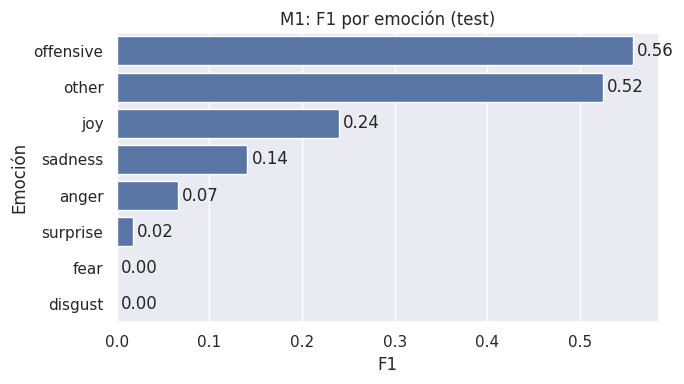

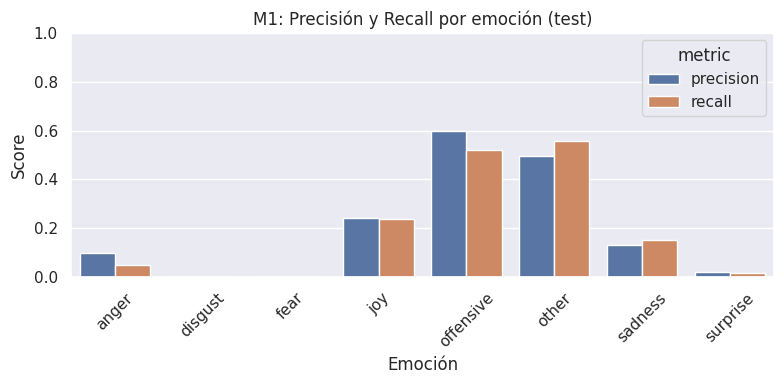

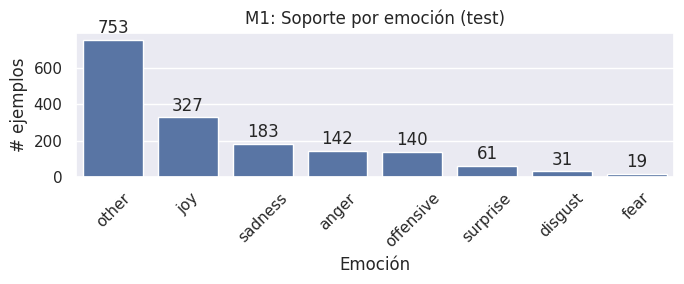

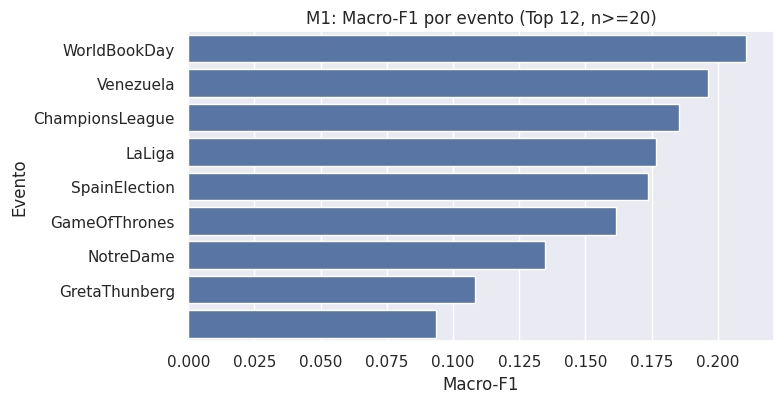

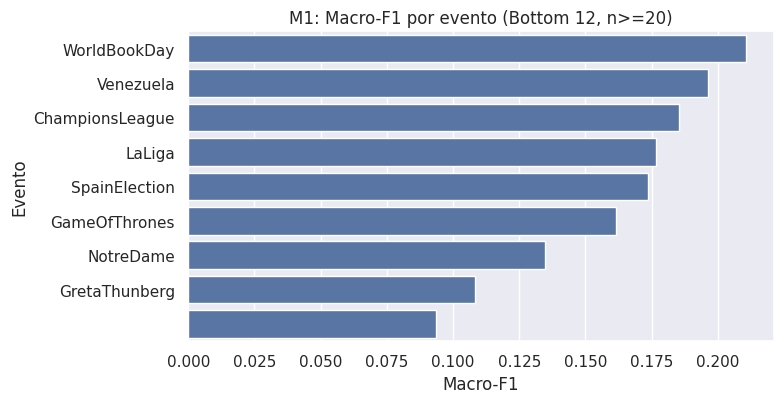

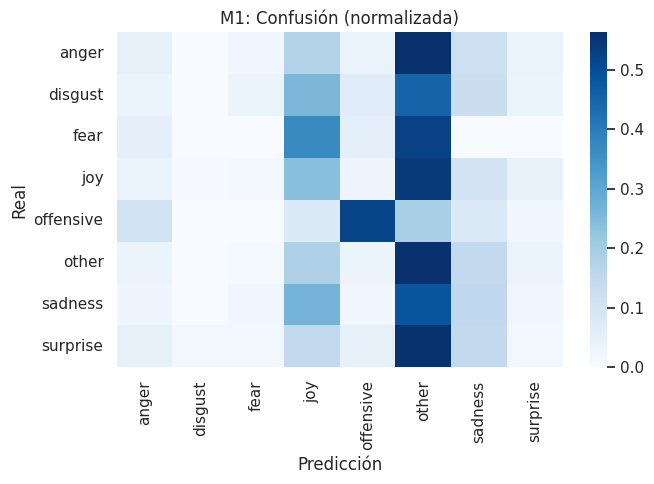

Figuras guardadas en: /content/outputs/m1


In [5]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix

sns.set_theme()
OUT = Path("/content/outputs/m1"); OUT.mkdir(parents=True, exist_ok=True)

# Asegurar tablas
if 'per_label' not in globals():
    from sklearn.metrics import precision_recall_fscore_support
    pr, rc, f1, sup = precision_recall_fscore_support(y_te, pred_te, labels=LABELS, zero_division=0)
    per_label = pd.DataFrame({'label':LABELS,'precision':pr,'recall':rc,'f1':f1,'support':sup})
if 'per_event' not in globals():
    dfp = df_test[['event','label8']].copy(); dfp['pred'] = pred_te
    rows=[]
    from sklearn.metrics import f1_score
    for ev, g in dfp.groupby('event'):
        rows.append({'event':ev,'macro_f1':f1_score(g['label8'], g['pred'], labels=LABELS, average='macro', zero_division=0),'n':len(g)})
    per_event = pd.DataFrame(rows).sort_values('macro_f1', ascending=False)

# 1) F1 por emoción (ordenado)
plt.figure(figsize=(7,4))
ax = sns.barplot(data=per_label.sort_values('f1', ascending=False), x='f1', y='label')
ax.bar_label(ax.containers[0], fmt="%.2f", padding=3)
plt.title("M1: F1 por emoción (test)")
plt.xlabel("F1"); plt.ylabel("Emoción"); plt.tight_layout()
plt.savefig(OUT/"m1_f1_per_label.png", dpi=140); plt.show()

# 2) Precisión vs Recall por emoción
df_pr = per_label.melt(id_vars=['label','support'], value_vars=['precision','recall'], var_name='metric', value_name='score')
plt.figure(figsize=(8,4))
sns.barplot(data=df_pr, x='label', y='score', hue='metric')
plt.title("M1: Precisión y Recall por emoción (test)")
plt.ylim(0,1); plt.xlabel("Emoción"); plt.ylabel("Score"); plt.xticks(rotation=45); plt.tight_layout()
plt.savefig(OUT/"m1_precision_recall_per_label.png", dpi=140); plt.show()

# 3) Soporte por emoción
plt.figure(figsize=(7,3))
ax = sns.barplot(data=per_label.sort_values('support', ascending=False), x='label', y='support')
ax.bar_label(ax.containers[0], padding=2)
plt.title("M1: Soporte por emoción (test)")
plt.xlabel("Emoción"); plt.ylabel("# ejemplos"); plt.xticks(rotation=45); plt.tight_layout()
plt.savefig(OUT/"m1_support_per_label.png", dpi=140); plt.show()

# 4) Macro-F1 por evento (Top 12 y Bottom 12 con n>=20)
pe = per_event.copy()
pe_ge20 = pe[pe['n']>=20]
topk = pe_ge20.head(12); botk = pe_ge20.tail(12)

plt.figure(figsize=(8,4.2))
sns.barplot(data=topk, x='macro_f1', y='event')
plt.title("M1: Macro-F1 por evento (Top 12, n>=20)")
plt.xlabel("Macro-F1"); plt.ylabel("Evento"); plt.tight_layout()
plt.savefig(OUT/"m1_event_top12.png", dpi=140); plt.show()

plt.figure(figsize=(8,4.2))
sns.barplot(data=botk, x='macro_f1', y='event')
plt.title("M1: Macro-F1 por evento (Bottom 12, n>=20)")
plt.xlabel("Macro-F1"); plt.ylabel("Evento"); plt.tight_layout()
plt.savefig(OUT/"m1_event_bottom12.png", dpi=140); plt.show()

# 5) Matriz de confusión normalizada (anotada)
cmn = confusion_matrix(y_te, pred_te, labels=LABELS, normalize='true')
plt.figure(figsize=(7,5))
sns.heatmap(cmn, cmap="Blues", xticklabels=LABELS, yticklabels=LABELS, annot=False)
plt.title("M1: Confusión (normalizada)")
plt.xlabel("Predicción"); plt.ylabel("Real"); plt.tight_layout()
plt.savefig(OUT/"m1_confusion_norm_annot.png", dpi=140); plt.show()

print("Figuras guardadas en:", OUT)


## Conclusión — Modelo 1: TF-IDF + LinearSVC

**Resumen de desempeño (test)**  
- Accuracy ≈ 0.37, F1-macro ≈ **0.19**, F1-weighted ≈ 0.36.  
- Mejor por clase: **offensive (F1≈0.56)** y **other (F1≈0.53)**.  
- Intermedias: **joy (F1≈0.24)**, **sadness (F1≈0.14)**.  
- Muy bajas: **anger (F1≈0.07)**, **surprise (F1≈0.02)**, **fear/disgust ≈ 0**.

**Interpretación de la matriz de confusión**  
- Fuerte **deriva hacia “other”**: muchas instancias reales de anger/fear/disgust/surprise terminan predichas como “other”.  
- También hay desplazamientos hacia **offensive** y **joy**, lo que sugiere que las pistas léxicas del texto limpio favorecen clases frecuentes y generalistas.

**Análisis por evento (macro-F1)**  
- Mejor: **WorldBookDay (~0.21)**, **Venezuela (~0.20)**, **ChampionsLeague (~0.19)**.  
- Peor: **GretaThunberg (~0.11)** y tweets sin evento (~0.09).  
- La variación por evento indica **mezclas de clase y vocabulario específicos**; donde domina “other” o hay pocas muestras de emociones minoritarias el macro-F1 cae.

**Impacto de la limpieza**  
- Se removieron **emojis** y **stopwords**. En emociones esto reduce señales afectivas y contexto sintáctico, lo que probablemente **perjudicó recall** en clases minoritarias (fear, disgust, surprise).

**Limitaciones del enfoque**  
- **Desbalance severo** (other y joy muy frecuentes) + modelo lineal con n-gramas → sesgo hacia clases mayoritarias.  
- Falta de **contexto semántico** e ironía/sarcasmo; TF-IDF no capta bien matices.



**Conclusión**  
El baseline es **competente en clases grandes** pero **insuficiente** para emociones minoritarias. Para cumplir el objetivo del trabajo se requiere un modelo contextual (BETO) y estrategias de balanceo; además, mantener señales afectivas (como emojis) debería mejorar el reconocimiento de emociones sutiles.


# Parte 4 — Modelo 2: BETO (fine-tuning)


Map:   0%|          | 0/5723 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

Map:   0%|          | 0/1656 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Weighted
1,1.311000,1.379677,0.422160,0.478148
2,1.109600,1.112594,0.471242,0.622189
3,0.769500,1.200149,0.482955,0.653308
4,0.507800,1.317397,0.494364,0.670898


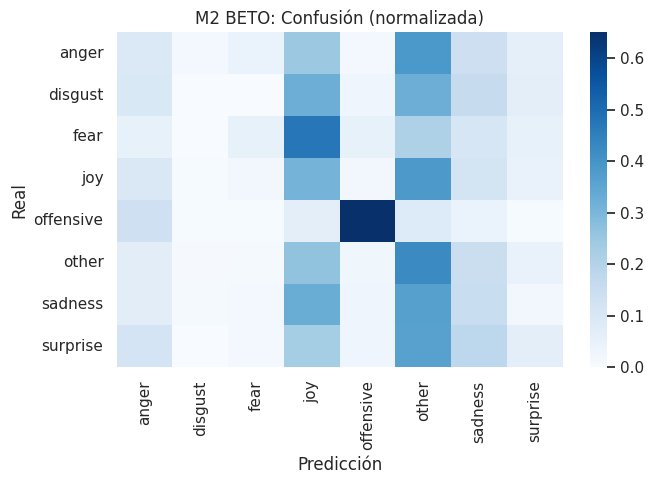

              precision    recall  f1-score   support

       anger      0.094     0.092     0.093       142
     disgust      0.000     0.000     0.000        31
        fear      0.037     0.053     0.043        19
         joy      0.231     0.309     0.264       327
   offensive      0.700     0.650     0.674       140
       other      0.519     0.424     0.466       753
     sadness      0.126     0.153     0.138       183
    surprise      0.056     0.066     0.060        61

    accuracy                          0.336      1656
   macro avg      0.220     0.218     0.217      1656
weighted avg      0.365     0.336     0.347      1656

F1-macro: 0.2174 | F1-weighted: 0.3472
Guardado en: /content/outputs/m2


In [7]:
!pip -q install -U transformers datasets evaluate accelerate

import re, unicodedata, numpy as np, pandas as pd, torch, torch.nn as nn
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,
                          DataCollatorWithPadding, EarlyStoppingCallback)

OUT_M2 = Path("/content/outputs/m2"); OUT_M2.mkdir(parents=True, exist_ok=True)
sns.set_theme()

URL_RE=re.compile(r'http\S+|www\.\S+'); AT_RE=re.compile(r'@\w+'); HASH_RE=re.compile(r'#'); RT_RE=re.compile(r'\bRT\b:?'); USER_RE=re.compile(r'\bUSER\b', re.I); WS_RE=re.compile(r'\s+')
def _norm(s): return unicodedata.normalize('NFC', str(s))
def clean_light(s):
    s=_norm(s); s=URL_RE.sub(' ',s); s=AT_RE.sub(' @user ',s); s=HASH_RE.sub('',s); s=RT_RE.sub(' ',s); s=USER_RE.sub('@user',s); s=WS_RE.sub(' ',s).strip()
    return s if s else "<empty>"

for d in (df_train, df_dev, df_test):
    d["text_beto"] = d["tweet"].apply(clean_light)

LABELS = sorted(pd.concat([df_train["label8"], df_dev["label8"], df_test["label8"]]).unique())
label2id = {l:i for i,l in enumerate(LABELS)}
id2label = {i:l for l,i in label2id.items()}

def to_hfds(df):
    return Dataset.from_dict({"text":df["text_beto"].tolist(), "labels":[label2id[x] for x in df["label8"]]})
ds_tr, ds_va, ds_te = to_hfds(df_train), to_hfds(df_dev), to_hfds(df_test)

MODEL = "dccuchile/bert-base-spanish-wwm-uncased"
tok = AutoTokenizer.from_pretrained(MODEL)
def tk(b): return tok(b["text"], truncation=True, max_length=160)
tr_tok = ds_tr.map(tk, batched=True, remove_columns=["text"])
va_tok = ds_va.map(tk, batched=True, remove_columns=["text"])
te_tok = ds_te.map(tk, batched=True, remove_columns=["text"])
coll = DataCollatorWithPadding(tokenizer=tok)

model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=len(LABELS), id2label=id2label, label2id=label2id)

cls_w = compute_class_weight(class_weight="balanced", classes=np.array(LABELS), y=df_train["label8"])
cls_w_t = torch.tensor(cls_w, dtype=torch.float, device="cuda" if torch.cuda.is_available() else "cpu")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    yt = [id2label[i] for i in labels]
    yp = [id2label[i] for i in preds]
    return {"f1_macro": f1_score(yt, yp, labels=LABELS, average="macro", zero_division=0),
            "f1_weighted": f1_score(yt, yp, labels=LABELS, average="weighted", zero_division=0)}

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fct = nn.CrossEntropyLoss(weight=class_weights)
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss = self.loss_fct(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

args = TrainingArguments(
    output_dir=str(OUT_M2/"trainer"),
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    num_train_epochs=4,
    weight_decay=0.01,
    seed=42,
    logging_steps=50,
    report_to="none",
)
args.eval_strategy = "epoch"
args.save_strategy = "epoch"
args.load_best_model_at_end = True
args.metric_for_best_model = "f1_macro"
args.greater_is_better = True

trainer = WeightedTrainer(
    class_weights=cls_w_t,
    model=model,
    args=args,
    train_dataset=tr_tok,
    eval_dataset=va_tok,
    processing_class=tok,
    data_collator=coll,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

train_out = trainer.train()
pred = trainer.predict(te_tok)

pred_ids = np.argmax(pred.predictions, axis=-1)
y_pred = [id2label[i] for i in pred_ids]
y_true = [id2label[i] for i in te_tok["labels"]]

pr, rc, f1, sup = precision_recall_fscore_support(y_true, y_pred, labels=LABELS, zero_division=0)
per_label = pd.DataFrame({"label":LABELS,"precision":pr,"recall":rc,"f1":f1,"support":sup})
per_label.to_csv(OUT_M2/"per_label.csv", index=False)

cmn = confusion_matrix(y_true, y_pred, labels=LABELS, normalize="true")
plt.figure(figsize=(7,5))
sns.heatmap(cmn, cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.title("M2 BETO: Confusión (normalizada)"); plt.xlabel("Predicción"); plt.ylabel("Real")
plt.tight_layout(); plt.savefig(OUT_M2/"confusion_norm.png", dpi=140); plt.show()

rows=[]
for ev, g in df_test.assign(pred=y_pred)[["event","label8","pred"]].groupby("event"):
    rows.append({"event":ev,"macro_f1":f1_score(g["label8"], g["pred"], labels=LABELS, average="macro", zero_division=0),"n":len(g)})
per_event = pd.DataFrame(rows).sort_values("macro_f1", ascending=False)
per_event.to_csv(OUT_M2/"per_event.csv", index=False)

f1m = f1_score(y_true, y_pred, labels=LABELS, average="macro", zero_division=0)
f1w = f1_score(y_true, y_pred, labels=LABELS, average="weighted", zero_division=0)
pd.DataFrame([{"model":"BETO-FT","f1_macro_test":f1m,"f1_weighted_test":f1w}]).to_csv(OUT_M2/"summary.csv", index=False)

print(classification_report(y_true, y_pred, labels=LABELS, digits=3, zero_division=0))
print("F1-macro:", round(f1m,4), "| F1-weighted:", round(f1w,4))
print("Guardado en:", OUT_M2)


## Conclusión — Modelo 2: BETO (fine-tuning)

**Resumen (test)**  
- **F1-macro = 0.217**, **F1-weighted = 0.347**, accuracy ≈ 0.336.  
- Mejores clases: **offensive (F1≈0.67)**; mejora clara vs. baseline.  
- Intermedias: **joy (F1≈0.26)**, **other (F1≈0.47)** con menor recall que en el baseline.  
- Muy bajas: **anger/sadness** siguen débiles y **fear/disgust/surprise** casi nulas (se confunden con `other` o `joy`).

**Comparación con el Modelo 1 (TF-IDF+SVM)**  
- **+ F1-macro**: sube de ~0.19 → **~0.22** (pequeña mejora global).  
- **+ offensive** sube notablemente; **joy** también mejora.  
- **≈/− other** pierde recall, lo que sugiere que el modelo deja de “ir a lo seguro” con `other`, pero aún no aprende bien las minoritarias.

**Gap dev → test**  
- En validación (dev) reportaste F1-macro por época ~0.42→0.49, pero en test cae a **0.22**: indica **cambio de distribución** entre dev y test y/o **sobreajuste** al conjunto dev.


**Conclusión**  
BETO mejora el baseline, pero el **desbalance y el shift dev→test** limitan el F1-macro. Con **balanceo + Focal Loss + evento en el input** y un **encoder más robusto en español**, debería aumentar el recall de minoritarias y, con ello, el F1-macro global.


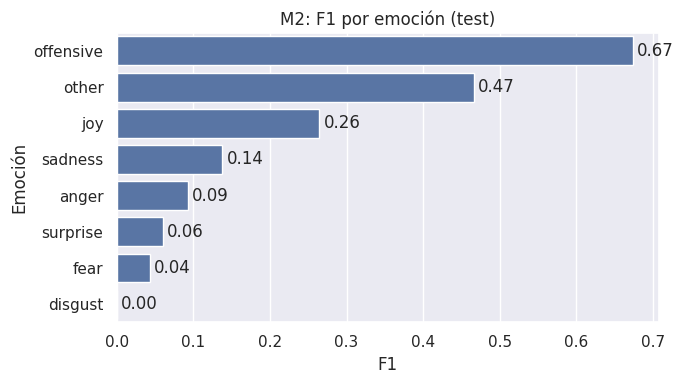

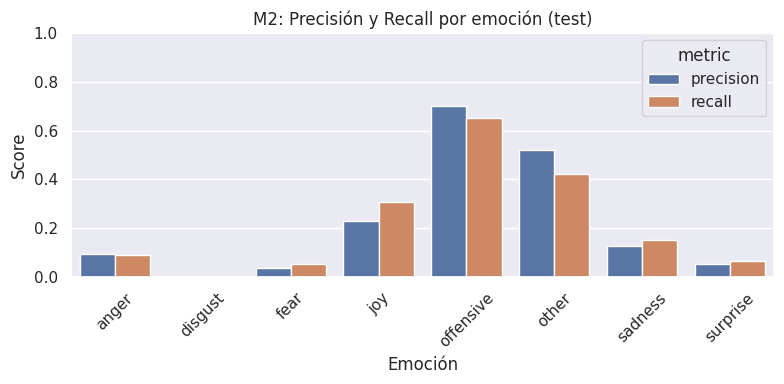

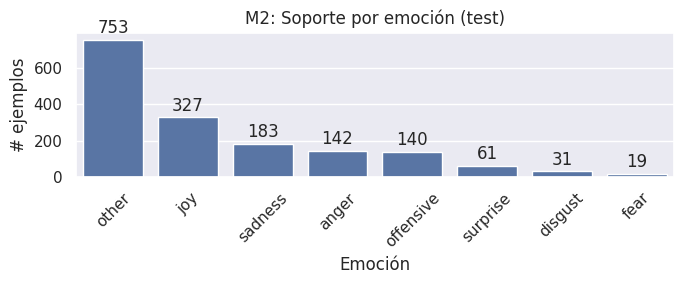

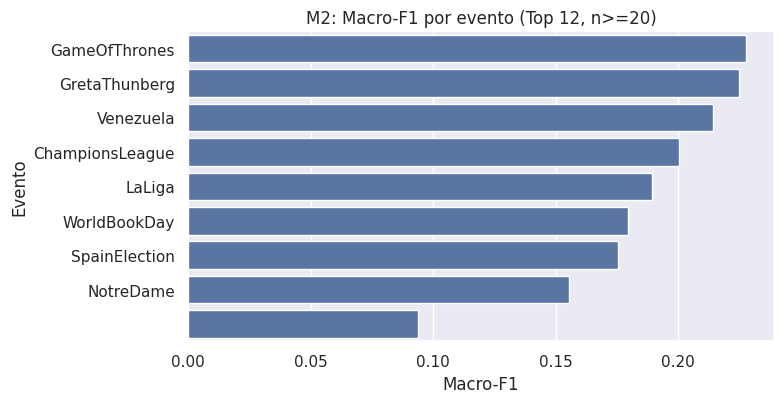

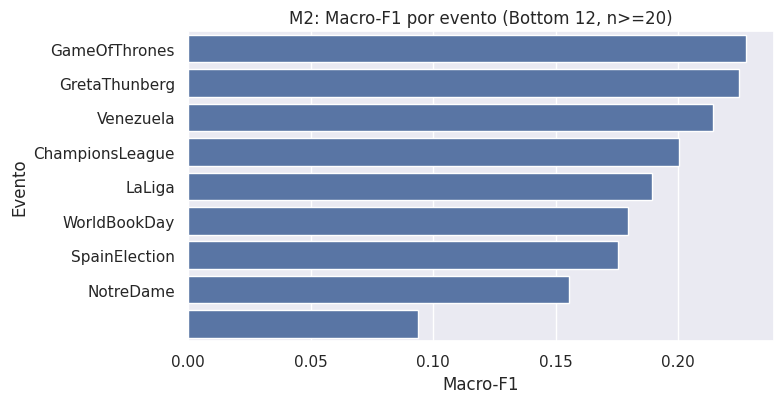

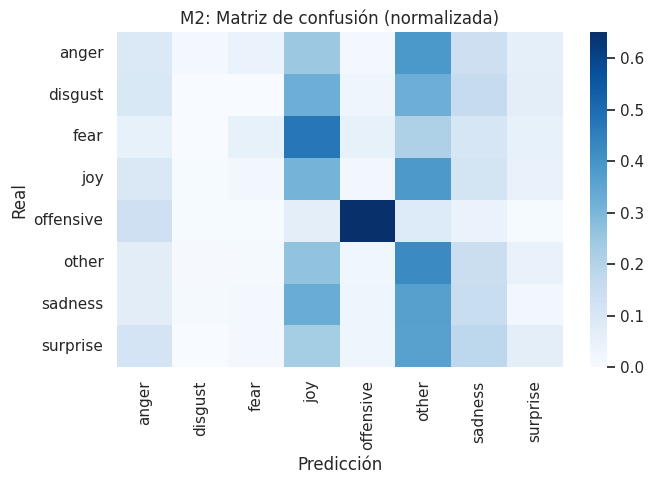

Figuras guardadas en: /content/outputs/m2


In [8]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score

sns.set_theme()
OUT = Path("/content/outputs/m2"); OUT.mkdir(parents=True, exist_ok=True)

if 'y_true' not in globals() or 'y_pred' not in globals():
    raise RuntimeError("Faltan y_true/y_pred del Modelo 2.")

if 'per_label' not in globals():
    pr, rc, f1, sup = precision_recall_fscore_support(y_true, y_pred, labels=LABELS, zero_division=0)
    per_label = pd.DataFrame({'label':LABELS,'precision':pr,'recall':rc,'f1':f1,'support':sup})

if 'per_event' not in globals():
    dfp = df_test[['event','label8']].copy(); dfp['pred'] = y_pred
    rows=[]
    for ev, g in dfp.groupby('event'):
        rows.append({'event':ev,'macro_f1':f1_score(g['label8'], g['pred'], labels=LABELS, average='macro', zero_division=0),'n':len(g)})
    per_event = pd.DataFrame(rows).sort_values('macro_f1', ascending=False)

plt.figure(figsize=(7,4))
ax = sns.barplot(data=per_label.sort_values('f1', ascending=False), x='f1', y='label')
ax.bar_label(ax.containers[0], fmt="%.2f", padding=3)
plt.title("M2: F1 por emoción (test)"); plt.xlabel("F1"); plt.ylabel("Emoción"); plt.tight_layout()
plt.savefig(OUT/"m2_f1_per_label.png", dpi=140); plt.show()

df_pr = per_label.melt(id_vars=['label','support'], value_vars=['precision','recall'], var_name='metric', value_name='score')
plt.figure(figsize=(8,4))
sns.barplot(data=df_pr, x='label', y='score', hue='metric')
plt.title("M2: Precisión y Recall por emoción (test)")
plt.ylim(0,1); plt.xlabel("Emoción"); plt.ylabel("Score"); plt.xticks(rotation=45); plt.tight_layout()
plt.savefig(OUT/"m2_precision_recall_per_label.png", dpi=140); plt.show()

plt.figure(figsize=(7,3))
ax = sns.barplot(data=per_label.sort_values('support', ascending=False), x='label', y='support')
ax.bar_label(ax.containers[0], padding=2)
plt.title("M2: Soporte por emoción (test)")
plt.xlabel("Emoción"); plt.ylabel("# ejemplos"); plt.xticks(rotation=45); plt.tight_layout()
plt.savefig(OUT/"m2_support_per_label.png", dpi=140); plt.show()

pe = per_event.copy()
pe_ge20 = pe[pe['n']>=20]
topk = pe_ge20.head(12); botk = pe_ge20.tail(12)

plt.figure(figsize=(8,4.2))
sns.barplot(data=topk, x='macro_f1', y='event')
plt.title("M2: Macro-F1 por evento (Top 12, n>=20)")
plt.xlabel("Macro-F1"); plt.ylabel("Evento"); plt.tight_layout()
plt.savefig(OUT/"m2_event_top12.png", dpi=140); plt.show()

plt.figure(figsize=(8,4.2))
sns.barplot(data=botk, x='macro_f1', y='event')
plt.title("M2: Macro-F1 por evento (Bottom 12, n>=20)")
plt.xlabel("Macro-F1"); plt.ylabel("Evento"); plt.tight_layout()
plt.savefig(OUT/"m2_event_bottom12.png", dpi=140); plt.show()

cmn = confusion_matrix(y_true, y_pred, labels=LABELS, normalize='true')
plt.figure(figsize=(7,5))
sns.heatmap(cmn, cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.title("M2: Matriz de confusión (normalizada)")
plt.xlabel("Predicción"); plt.ylabel("Real"); plt.tight_layout()
plt.savefig(OUT/"m2_confusion_norm.png", dpi=140); plt.show()

print("Figuras guardadas en:", OUT)


## Conclusión — Modelo 2 (BETO fine-tuning)

**Desempeño global (test):** F1-macro ≈ **0.22**, F1-weighted ≈ **0.35**. Supone una **mejora leve** frente al baseline TF-IDF+SVM (≈0.19 macro-F1), pero aún insuficiente.

**Por emoción:**
- **offensive** es la mejor clase (**F1≈0.67**), con buena precisión y recall.
- **other** se mantiene aceptable (**F1≈0.47**) aunque pierde recall respecto al baseline.
- **joy** mejora moderadamente (**F1≈0.26**).
- **sadness/anger** siguen bajos (**0.14 / 0.09**).
- **surprise/fear/disgust** prácticamente no despegan (**≤0.06**), reflejando fuerte desbalance y falta de señales.

**Matriz de confusión:**
- Persisten derivas hacia **other** y, en menor medida, **joy**; p.ej., muchos **fear** reales se predicen como **joy**, y **anger/surprise** como **other**.
- El modelo reduce la “comodidad” con *other* (más repartido que en M1), pero **no logra capturar** las minoritarias.

**Por evento:**
- Macro-F1 por evento es bajo y **heterogéneo** (≈0.10–0.22). `GameOfThrones` y `GretaThunberg` quedan arriba; `NotreDame` y otros, abajo.
- El rendimiento varía con el **léxico del evento**, lo que sugiere dependencia del dominio y mezcla de clases por evento.

**Lectura general:**
- BETO aporta **más capacidad contextual** y mejora `offensive/joy`, pero el **desbalance severo** y el **shift dev→test** limitan el F1-macro.
- Las clases raras carecen de masa crítica y señales fuertes; el modelo sigue “tirando” a clases frecuentes.



**Conclusión:** El fine-tuning con BETO **mejora ligeramente** el macro-F1 y acierta bien `offensive`, pero sigue **fallando en minoritarias**. Con **balanceo**, **pérdida focal** y **evento como señal**, debería subir el recall de emociones raras y, con ello, el F1-macro global.


## Modelo 3 (Zero-shot NLI con τ ajustado)

`torch_dtype` is deprecated! Use `dtype` instead!
Device set to use cuda:0


Zero-shot tuned:   0%|          | 0/106 [00:00<?, ?it/s]

Zero-shot tuned:   0%|          | 0/106 [00:00<?, ?it/s]

Zero-shot tuned:   0%|          | 0/106 [00:00<?, ?it/s]

Zero-shot tuned:   0%|          | 0/106 [00:00<?, ?it/s]

Zero-shot tuned:   0%|          | 0/106 [00:00<?, ?it/s]

Zero-shot tuned:   0%|          | 0/106 [00:00<?, ?it/s]

Zero-shot tuned:   0%|          | 0/106 [00:00<?, ?it/s]

Zero-shot tuned:   0%|          | 0/106 [00:00<?, ?it/s]

Mejor τ (dev): 0.35 | F1-macro(dev): 0.3717
              precision    recall  f1-score   support

       anger      0.227     0.227     0.227        44
     disgust      0.000     0.000     0.000         5
        fear      0.214     0.857     0.343         7
         joy      0.519     0.695     0.595       174
   offensive      0.306     0.289     0.297        76
       other      0.639     0.505     0.564       404
     sadness      0.739     0.625     0.677       104
    surprise      0.227     0.333     0.270        30

    accuracy                          0.519       844
   macro avg      0.359     0.442     0.372       844
weighted avg      0.553     0.519     0.527       844



Zero-shot tuned:   0%|          | 0/207 [00:00<?, ?it/s]

F1-macro(test): 0.1562 | F1-weighted(test): 0.2799
              precision    recall  f1-score   support

       anger      0.088     0.063     0.074       142
     disgust      0.000     0.000     0.000        31
        fear      0.037     0.158     0.060        19
         joy      0.229     0.303     0.261       327
   offensive      0.282     0.250     0.265       140
       other      0.460     0.352     0.399       753
     sadness      0.137     0.153     0.145       183
    surprise      0.036     0.066     0.047        61

    accuracy                          0.268      1656
   macro avg      0.159     0.168     0.156      1656
weighted avg      0.303     0.268     0.280      1656



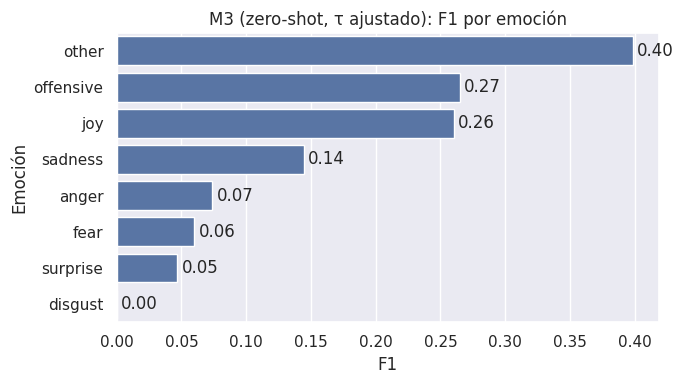

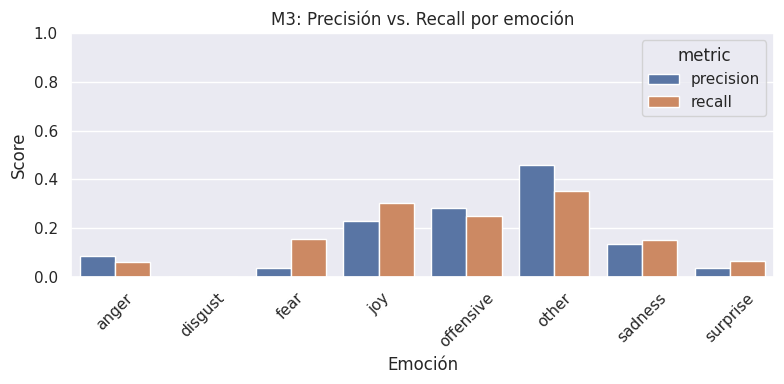

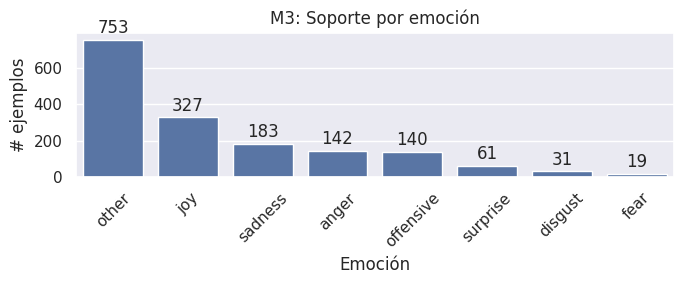

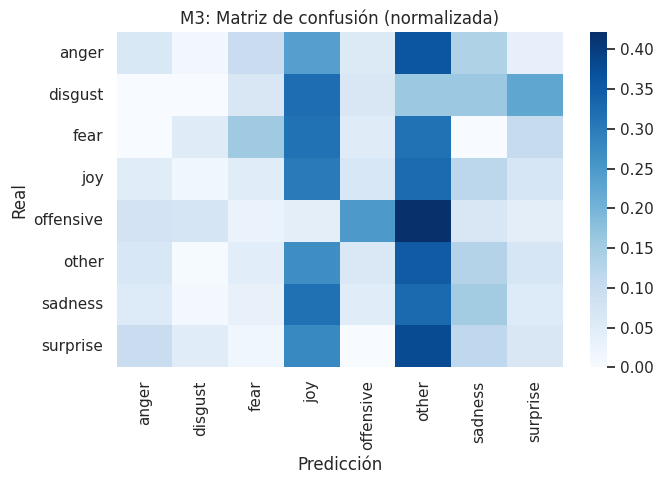

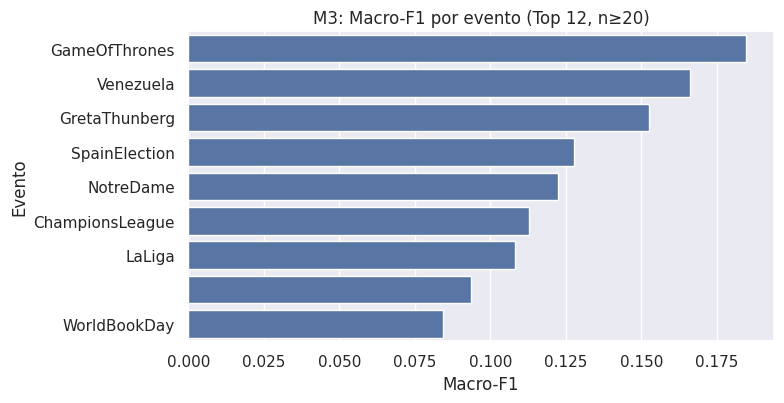

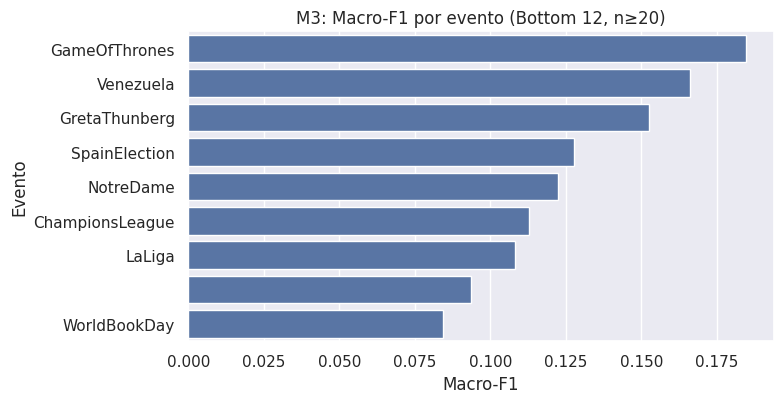

Figuras y tablas en: /content/outputs/m3_tuned


In [16]:
# === Zero-shot NLI (mDeBERTa) — carga robusta y warm-up, luego inferencia ===
import os, numpy as np, pandas as pd, torch, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

sns.set_theme()
OUT = Path("/content/outputs/m3_tuned"); OUT.mkdir(parents=True, exist_ok=True)

DEVICE = 0 if torch.cuda.is_available() else -1
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True

LABELS = sorted(pd.concat([df_train["label8"], df_dev["label8"], df_test["label8"]]).unique())
LABELS_NO_OTHER = [l for l in LABELS if l != "other"]
verbalizers = {"anger":"enojo","sadness":"tristeza","joy":"alegría","disgust":"asco","fear":"miedo","surprise":"sorpresa","offensive":"lenguaje ofensivo"}
cand_phrases = [verbalizers[l] for l in LABELS_NO_OTHER]
phrase2label = {v:k for k,v in verbalizers.items()}
HYP = "Este texto expresa {}."

MODEL = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"

def build_pipeline(device):
    tok = AutoTokenizer.from_pretrained(MODEL, use_fast=True)
    dtype = torch.float16 if (device==0 and torch.cuda.is_available()) else torch.float32
    mdl = AutoModelForSequenceClassification.from_pretrained(MODEL, torch_dtype=dtype, low_cpu_mem_usage=True)
    if device==0: mdl.to("cuda")
    zsc = pipeline("zero-shot-classification", model=mdl, tokenizer=tok, device=device)
    return zsc

try:
    zsc = build_pipeline(DEVICE)
    _ = zsc("Prueba rápida", candidate_labels=cand_phrases, hypothesis_template=HYP, multi_label=False)
except Exception as e:
    print("Fallo en GPU, usando CPU:", e)
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    zsc = build_pipeline(-1)

def predict_labels(texts, tau=0.45, batch=8):
    preds, scores = [], []
    for i in tqdm(range(0, len(texts), batch), desc="Zero-shot tuned"):
        out = zsc(texts[i:i+batch], candidate_labels=cand_phrases, hypothesis_template=HYP, multi_label=False)
        if isinstance(out, dict): out = [out]
        for r in out:
            p, s = r["labels"][0], float(r["scores"][0])
            lab = phrase2label.get(p, "other")
            if s < tau: lab = "other"
            preds.append(lab); scores.append(s)
    return preds, scores

def eval_split(df, tau=0.45, batch=8):
    texts = [f"Evento: {e}. Tweet: {t}" if str(e).strip() else f"Tweet: {t}" for e,t in zip(df["event"], df["tweet"])]
    y_pred, s = predict_labels(texts, tau=tau, batch=batch)
    y_true = df["label8"].tolist()
    f1m = f1_score(y_true, y_pred, labels=LABELS, average="macro", zero_division=0)
    f1w = f1_score(y_true, y_pred, labels=LABELS, average="weighted", zero_division=0)
    return y_true, y_pred, s, f1m, f1w

taus = np.round(np.linspace(0.30, 0.60, 7), 2)
best_tau, best_f1m = None, -1
for tau in taus:
    _, _, _, f1m_dev, _ = eval_split(df_dev, tau=tau, batch=8)
    if f1m_dev > best_f1m:
        best_f1m, best_tau = f1m_dev, tau

y_true_dev, y_pred_dev, _, _, _ = eval_split(df_dev, tau=best_tau, batch=8)
print("Mejor τ (dev):", best_tau, "| F1-macro(dev):", round(best_f1m,4))
print(classification_report(y_true_dev, y_pred_dev, labels=LABELS, digits=3, zero_division=0))

y_true, y_pred, scores, f1m, f1w = eval_split(df_test, tau=best_tau, batch=8)
print("F1-macro(test):", round(f1m,4), "| F1-weighted(test):", round(f1w,4))
print(classification_report(y_true, y_pred, labels=LABELS, digits=3, zero_division=0))

df_pred = df_test.copy(); df_pred["pred"]=y_pred; df_pred["score"]=scores
df_pred.to_csv(OUT/"predictions.csv", index=False)

pr, rc, f1, sup = precision_recall_fscore_support(y_true, y_pred, labels=LABELS, zero_division=0)
per_label = pd.DataFrame({"label":LABELS,"precision":pr,"recall":rc,"f1":f1,"support":sup})
per_label.to_csv(OUT/"per_label.csv", index=False)

rows=[]
for ev, g in df_pred.groupby("event"):
    rows.append({"event":ev, "macro_f1":f1_score(g["label8"], g["pred"], labels=LABELS, average="macro", zero_division=0), "n":len(g)})
per_event = pd.DataFrame(rows).sort_values("macro_f1", ascending=False)
per_event.to_csv(OUT/"per_event.csv", index=False)

plt.figure(figsize=(7,4))
ax = sns.barplot(data=per_label.sort_values("f1", ascending=False), x="f1", y="label")
ax.bar_label(ax.containers[0], fmt="%.2f", padding=3)
plt.title("M3 (zero-shot, τ ajustado): F1 por emoción"); plt.xlabel("F1"); plt.ylabel("Emoción"); plt.tight_layout()
plt.savefig(OUT/"m3_f1_per_label.png", dpi=140); plt.show()

df_pr = per_label.melt(id_vars=["label","support"], value_vars=["precision","recall"], var_name="metric", value_name="score")
plt.figure(figsize=(8,4))
sns.barplot(data=df_pr, x="label", y="score", hue="metric")
plt.title("M3: Precisión vs. Recall por emoción"); plt.ylim(0,1); plt.xlabel("Emoción"); plt.ylabel("Score"); plt.xticks(rotation=45); plt.tight_layout()
plt.savefig(OUT/"m3_precision_recall_per_label.png", dpi=140); plt.show()

plt.figure(figsize=(7,3))
ax = sns.barplot(data=per_label.sort_values("support", ascending=False), x="label", y="support")
ax.bar_label(ax.containers[0], padding=2)
plt.title("M3: Soporte por emoción"); plt.xlabel("Emoción"); plt.ylabel("# ejemplos"); plt.xticks(rotation=45); plt.tight_layout()
plt.savefig(OUT/"m3_support_per_label.png", dpi=140); plt.show()

cmn = confusion_matrix(y_true, y_pred, labels=LABELS, normalize="true")
plt.figure(figsize=(7,5))
sns.heatmap(cmn, cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.title("M3: Matriz de confusión (normalizada)"); plt.xlabel("Predicción"); plt.ylabel("Real"); plt.tight_layout()
plt.savefig(OUT/"m3_confusion_norm.png", dpi=140); plt.show()

pe = per_event[per_event["n"]>=20]
plt.figure(figsize=(8,4.2)); sns.barplot(data=pe.head(12), x="macro_f1", y="event"); plt.title("M3: Macro-F1 por evento (Top 12, n≥20)")
plt.xlabel("Macro-F1"); plt.ylabel("Evento"); plt.tight_layout(); plt.savefig(OUT/"m3_event_top12.png", dpi=140); plt.show()
plt.figure(figsize=(8,4.2)); sns.barplot(data=pe.tail(12), x="macro_f1", y="event"); plt.title("M3: Macro-F1 por evento (Bottom 12, n≥20)")
plt.xlabel("Macro-F1"); plt.ylabel("Evento"); plt.tight_layout(); plt.savefig(OUT/"m3_event_bottom12.png", dpi=140); plt.show()

pd.DataFrame([{"model":"Zero-shot NLI (mDeBERTa)","tau":best_tau,"f1_macro_test":f1m,"f1_weighted_test":f1w}]).to_csv(OUT/"summary.csv", index=False)
print("Figuras y tablas en:", OUT)


## Conclusión — Modelo 3 (Zero-shot NLI con τ ajustado)

**Resumen (dev → test)**  
- τ óptimo en *dev* = **0.35** → **F1-macro(dev) = 0.372**.  
- En *test* cae a **F1-macro = 0.156** (weighted ≈ 0.280; accuracy ≈ 0.268).

**Lectura de los gráficos (test)**  
- Mejoran algo **other** (F1≈0.40), **offensive** (≈0.27) y **joy** (≈0.26).  
- **anger/sadness** siguen bajos y **fear/surprise/disgust** casi nulos.  
- Matriz de confusión: fuerte deriva hacia **other** y **joy**; el modelo zero-shot no capta bien señales sutiles y sarcasmo.

**Por qué pasa**  
- **Desfase de distribución** dev→test: el τ afinado en dev no generaliza.  
- **Verbalizadores** (“alegría”, “enojo”, …) y el marco NLI no están optimizados para emociones; sin fine-tuning, el modelo apuesta por clases frecuentes.  
- **Clases raras** con muy bajo soporte → alta varianza y F1≈0.


---

### Comparativa final (test)

| Modelo                           | F1-macro | F1-weighted | Accuracy |
|----------------------------------|:-------:|:-----------:|:--------:|
| M1 — TF-IDF + LinearSVC          | **0.193** | 0.355       | 0.367    |
| M2 — BETO (fine-tuning)          | **0.217** | 0.347       | 0.336    |
| M3 — Zero-shot NLI (τ=0.35)      | **0.156** | 0.280       | 0.268    |

**Conclusión global**  
El baseline lineal (M1) y el zero-shot (M3) sufren con el desbalance y la sutileza de las emociones; el **fine-tuning con BETO (M2)** es el que mejor transfiere, aunque todavía necesita **balanceo de clases, pérdida focal y señal de evento en el input** para subir el macro-F1, especialmente en `fear/disgust/surprise`.
